### Install and load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

Suppress warnings

In [2]:
warnings.filterwarnings("ignore")

### Run R to download tsibble datasets and save as CSV

In [3]:
#!pip install rpy2

In [4]:
# %load_ext rpy2.ipython

In [5]:
# %%R
# library(tsibbledata)
# data("aus_production")
# write.csv(aus_production, "aus_production.csv", row.names=FALSE)
# data("gafa_stock")
# write.csv(gafa_stock, "gafa_stock.csv", row.names=FALSE)

## ACF
* Generate and plot white noise data

In [6]:
np.random.seed(30)

In [7]:
wn = np.random.normal(size=50)
y = pd.DataFrame({'wn': wn}, index=pd.RangeIndex(start=1, stop=51, name='sample'))

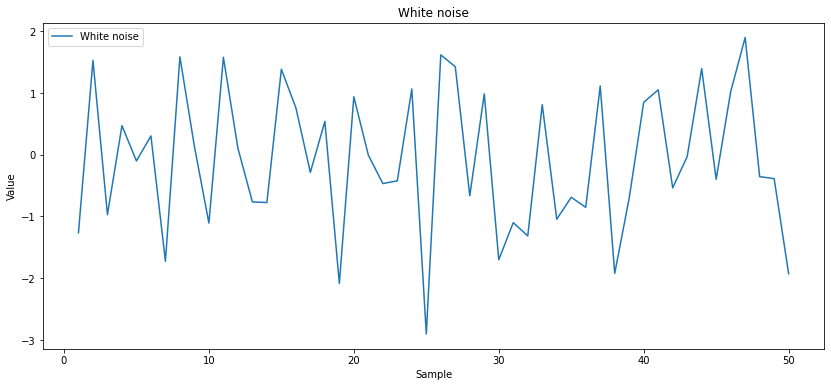

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(y.index, y['wn'], label='White noise')
plt.title('White noise')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

* Plot the white noise ACF

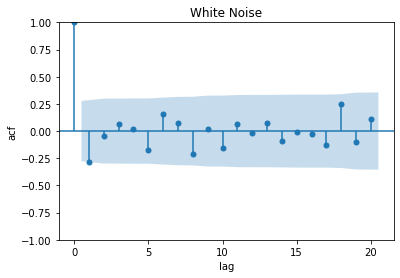

In [9]:
plot_acf(y['wn'], lags=20)
plt.title('White Noise')
plt.xlabel('lag')
plt.ylabel('acf')
plt.show()

## Simple forecasting methods to use as baseline
* Prepare the dataset: Bricks produced in Australia

In [10]:
def quarter_to_period(quarter_str):
    year, qtr = quarter_str.split(' Q')
    qtr_month = (int(qtr) - 1) * 3 + 1  # Convert quarter to start month
    return pd.Period(f"{year}-{qtr_month:02d}-01", freq='Q')

In [11]:
aus_production_df = pd.read_csv('aus_production.csv', parse_dates=['Quarter'])
aus_production_df['Quarter'] = aus_production_df['Quarter'].apply(quarter_to_period)
aus_production_df.set_index('Quarter', inplace=True)
aus_production_df.index = aus_production_df.index.to_timestamp()

In [12]:
bricks = aus_production_df.loc['1970-01-01':'2004-12-31', ['Bricks']]

* Create plot function

In [13]:
def plot_forecast(model, data, steps=8):
    model_fit = model.fit()
    forecast_index = pd.date_range(start=data.index[-1], periods=steps+1, freq='Q')[1:]
    forecast = model_fit.forecast(steps=steps)
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label='Actual')
    plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Bricks (Millions)')
    plt.legend()
    plt.show()

### Mean method

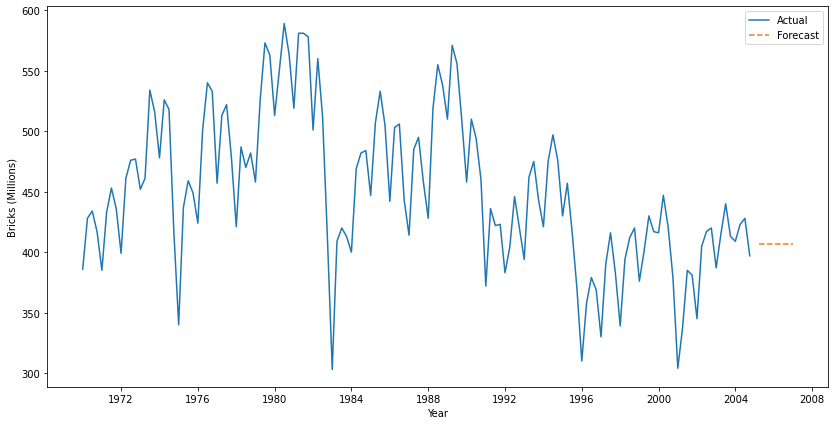

In [14]:
mean_model = SimpleExpSmoothing(bricks)
plot_forecast(mean_model, bricks)

In [15]:
def fit_and_plot_forecast(data, model_class, seasonal_periods=None, trend=None, steps=8):
    if seasonal_periods:
        model = model_class(data, seasonal_periods=seasonal_periods, trend=trend, initialization_method="estimated")
    else:
        model = model_class(data, initialization_method="estimated")
    
    model_fit = model.fit()
    forecast_index = pd.date_range(start=data.index[-1], periods=steps+1, freq='Q')[1:]
    forecast = model_fit.forecast(steps=steps)
    
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label='Actual')
    plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')
    plt.legend()
    plt.show()

### Naive (or random walk) method


In [16]:
def fit_and_plot_naive_forecast(series, steps=8):
    last_observed = series.iloc[-1]
    naive_forecast = np.repeat(last_observed, steps)
    forecast_index = pd.date_range(start=series.index[-1], periods=steps+1, freq=series.index.freq)[1:]
    
    plt.figure(figsize=(14, 7))
    plt.plot(series.index, series, label='Actual')
    plt.plot(forecast_index, naive_forecast, label='Naive Forecast', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Bricks (Millions)')
    plt.legend()
    plt.show()

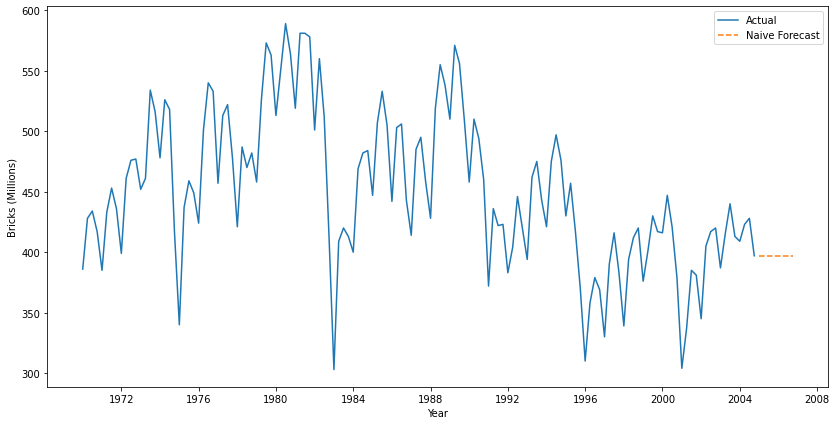

In [17]:
fit_and_plot_naive_forecast(bricks, steps=8)

### Seasonal naive method

In [18]:
def seasonal_naive_forecast(data, steps=8):
    last_seasons = data.iloc[-4:].values
    forecast = np.tile(last_seasons, int(np.ceil(steps/4)))[0:steps]
    forecast_index = pd.date_range(start=data.index[-1], periods=steps+1, freq='Q')[1:]
    
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label='Actual')
    plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')
    plt.xlabel('Year')
    plt.ylabel('Bricks (Millions)')
    plt.legend()
    plt.show()

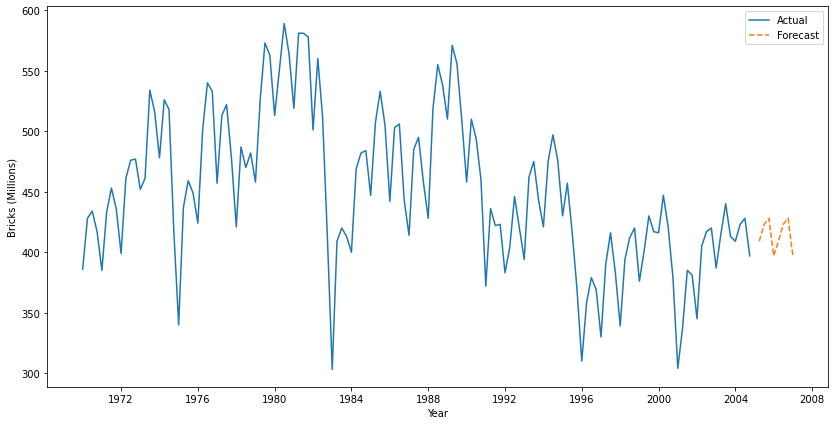

In [19]:
seasonal_naive_forecast(bricks['Bricks'])

### Drift method

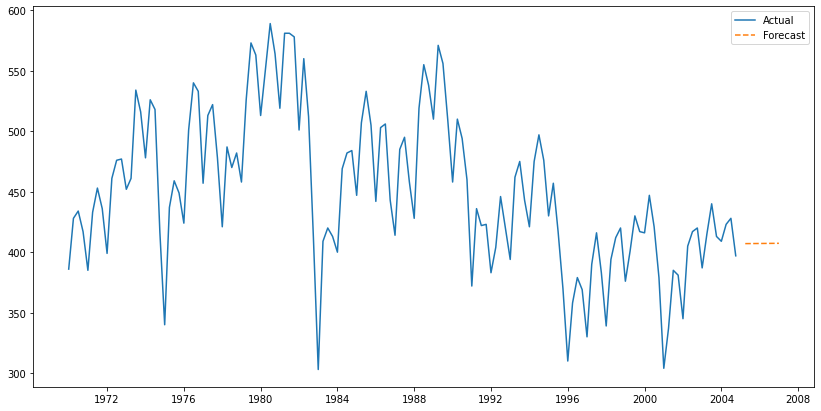

In [20]:
drift_model = Holt(bricks['Bricks'])
fit_and_plot_forecast(bricks['Bricks'], Holt, trend='add')

* The model fitted values and forecast looks like the ones from the Naive method.
* But lets try to use a different time period:

In [21]:
def plot_forecast_drift(model_fit, data, steps=8):
    forecast_index = pd.date_range(start=data.index[-1], periods=steps+1, freq='Q')[1:]
    forecast = model_fit.forecast(steps=steps)
    
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label='Actual')
    plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')
    plt.title('1970-1980')
    plt.xlabel('Year')
    plt.ylabel('Bricks (Millions)')
    plt.legend()
    plt.show()

In [22]:
bricks_1970_1980 = bricks.loc['1970-01-01':'1980-03-31', ['Bricks']]
holt_model_1970_1980 = Holt(bricks_1970_1980['Bricks'], initialization_method="estimated")
holt_fit_1970_1980 = holt_model_1970_1980.fit()

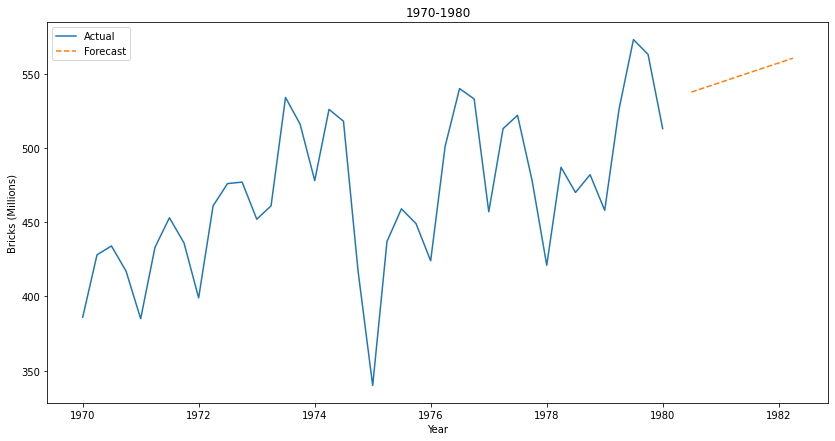

In [23]:
plot_forecast_drift(holt_fit_1970_1980, bricks_1970_1980['Bricks'])

### Example: Australian quarterly beer production


In [24]:
train_beer = aus_production_df.loc['1992-01-01':'2006-12-31', ['Beer']]
train_beer_head_tail = pd.concat([train_beer.head(), train_beer.tail()])
train_beer_head_tail

,Beer
Quarter,
1992-01-01,443
1992-04-01,410
1992-07-01,420
1992-10-01,532
1993-01-01,433
2005-10-01,482
2006-01-01,438
2006-04-01,386
2006-07-01,405


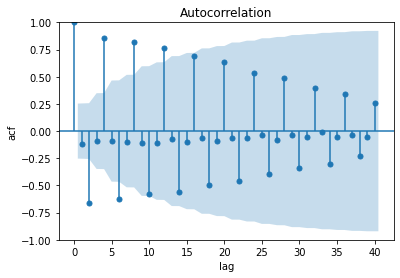

In [25]:
plot_acf(train_beer['Beer'], lags=40)
plt.xlabel('lag')
plt.ylabel('acf')
plt.show()

In [26]:
def fit_models(data):
    mean_model = SimpleExpSmoothing(data).fit()
    naive_forecast = np.repeat(data.iloc[-1], len(data))
    seasonal_naive_forecast = data.copy()
    for i in range(4, len(data)):
        seasonal_naive_forecast.iloc[i] = data.iloc[i - 4]
    return mean_model, naive_forecast, seasonal_naive_forecast

mean_model, naive_forecast, seasonal_naive_forecast = fit_models(train_beer['Beer'])



In [27]:
def plot_forecasts(data, mean_model, naive_forecast, seasonal_naive_forecast, steps=14):
    forecast_index = pd.date_range(start=data.index[-1], periods=steps+1, freq='Q')[1:]
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label='Actual')
    
    mean_forecast = mean_model.forecast(steps=steps)
    plt.plot(forecast_index, mean_forecast, label='Mean Forecast', linestyle='--', color='red')
    
    naive_forecast_line = np.repeat(data.iloc[-1], steps)
    plt.plot(forecast_index, naive_forecast_line, label='Naive Forecast', linestyle='--', color='gray')
    
    seasonal_naive_plot_forecast = np.tile(seasonal_naive_forecast.iloc[-4:].values, int(np.ceil(steps/4)))[:steps]
    plt.plot(forecast_index, seasonal_naive_plot_forecast, label='Seasonal Naive Forecast', linestyle='--', color='green')
    
    plt.title('Forecasts for Quarterly Beer Production')
    plt.xlabel('Year')
    plt.ylabel('Megalitres')
    plt.legend()
    plt.show()

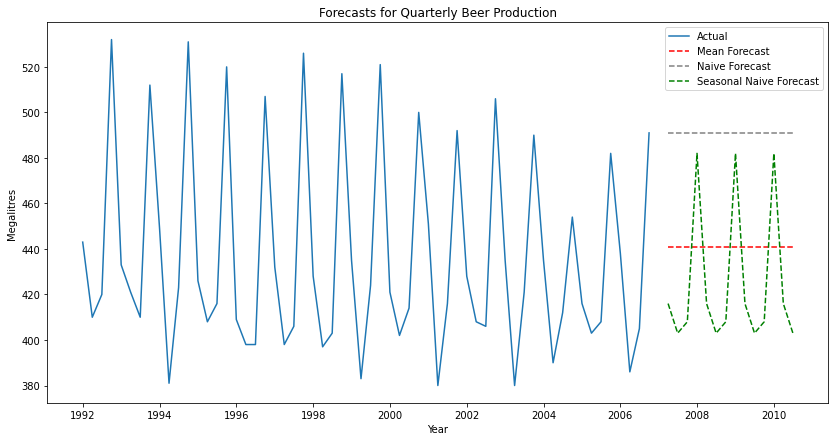

In [28]:
plot_forecasts(train_beer['Beer'], mean_model, naive_forecast, seasonal_naive_forecast)


### Example: Google’s daily closing stock price

* Use a regular time index instead of an irregular one

In [29]:
gafa_stock = pd.read_csv('gafa_stock.csv')

In [30]:
google_stock = gafa_stock[gafa_stock['Symbol'] == 'GOOG']
google_stock['Date'] = pd.to_datetime(google_stock['Date'])
google_stock = google_stock[google_stock['Date'].dt.year >= 2015]
google_stock['day'] = range(1, len(google_stock) + 1)
google_2015 = google_stock[google_stock['Date'].dt.year == 2015]
google_jan_2016 = google_stock[google_stock['Date'].dt.to_period('M') == '2016-01']


* Filter and plot the variable of interest

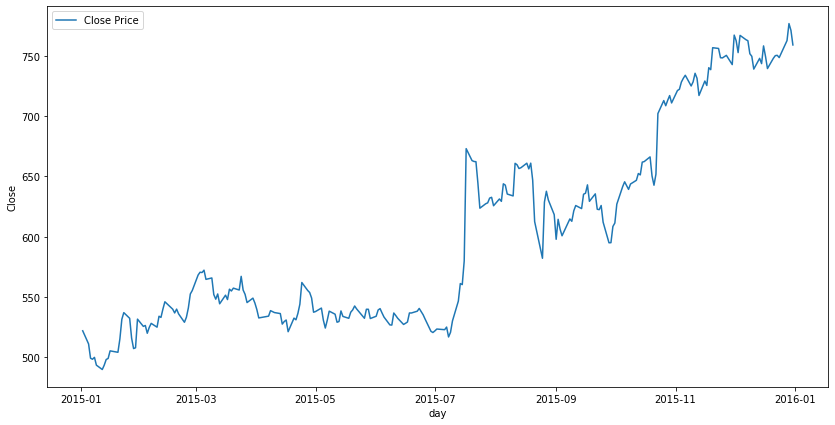

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(google_2015['Date'], google_2015['Close'], label='Close Price')
plt.xlabel('day')
plt.ylabel('Close')
plt.legend()
plt.show()

* Plot the ACF

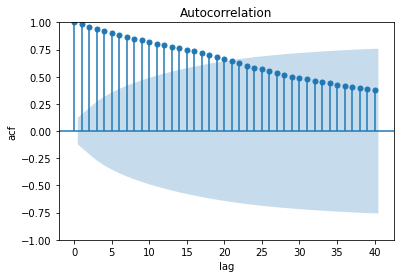

In [32]:
plot_acf(google_2015['Close'], lags=40)
plt.xlabel('lag')
plt.ylabel('acf')
plt.show()

* Fit mean, naive and drift model to data from 2015

In [33]:
google_fit_mean = SimpleExpSmoothing(google_2015['Close']).fit()
naive_forecast_google_2015 = np.repeat(google_2015['Close'].iloc[-1], len(google_2015))
google_fit_drift = ExponentialSmoothing(google_2015['Close'], trend='add', damped_trend=False, seasonal=None).fit()


* Predict values for 2016/Jan

In [34]:
mean_forecast_value_google = google_2015['Close'].mean()
naive_value_google = google_2015['Close'].iloc[-1]
drift_forecast_google = google_fit_drift.forecast(steps=20)

In [35]:
forecast_index_google = pd.date_range(start=google_2015['Date'].iloc[-1], periods=len(drift_forecast_google)+1, freq='B')[1:]

* Plot the forecasts

In [36]:
def plot_forecasts_google(data, mean_forecast, naive_value, drift_forecast, forecast_dates, actual_jan_2016):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data, label='Actual 2015', color='blue')
    plt.plot(actual_jan_2016.index, actual_jan_2016, label='Actual Jan 2016', color='black', linestyle='dashed', linewidth=1)

    plt.plot(forecast_dates, mean_forecast, label='Mean Forecast', linestyle='--', color='red', linewidth=1)

    plt.hlines(y=naive_value, xmin=forecast_dates[0], xmax=forecast_dates[-1], colors='gray', label='Naive Forecast', linestyles='--', linewidth=1)

    plt.plot(forecast_dates, drift_forecast, label='Drift Forecast', linestyle='--', color='purple', linewidth=1)
    
    plt.title('Google daily closing stock prices (Jan 2015 - Jan 2016)')
    plt.xlabel('day')
    plt.ylabel('$US')
    plt.legend()
    plt.show()

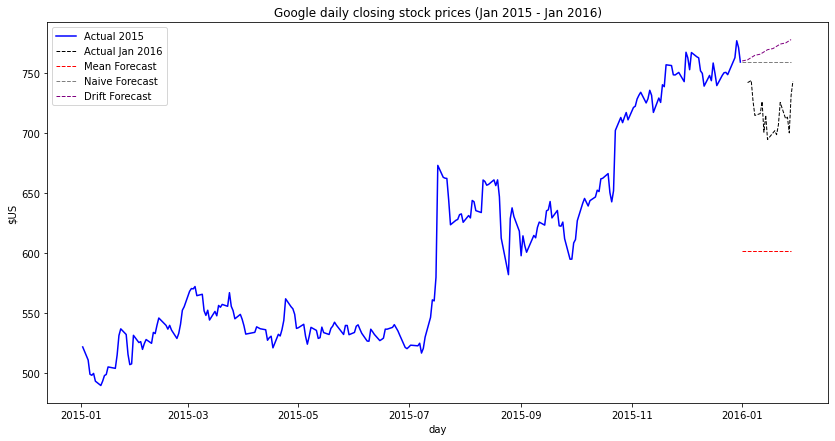

In [37]:
plot_forecasts_google(
    google_2015.set_index('Date')['Close'],
    np.full(forecast_index_google.shape, mean_forecast_value_google),
    naive_value_google,
    drift_forecast_google,
    forecast_index_google,
    google_jan_2016.set_index('Date')['Close']
)